# Bibliotecas

In [1]:
import Pkg; 
#Pkg.precompile()
#Pkg.add("RecipesBase");
#Pkg.add("Shapefile");
#Pkg.add("GeometricalPredicates")
#Pkg.add("GeoInterface")
#Pkg.add("GeometryBasics")
#Pkg.add("GeoDataFrames")
#Pkg.add("ArchGDAL")
#Pkg.add("PolygonOps")
#Pkg.add("StaticArrays")
#Pkg.add("CSV")

In [2]:
using RecipesBase
using Shapefile
using GeoInterface
using PolygonOps
using StaticArrays
using GeoDataFrames; const GDF=GeoDataFrames
using DataFrames
using CSV
using ColorSchemes
using ArchGDAL

using Distributions, Statistics
using Clustering
using Plots, GeometryBasics, VoronoiCells
using StatsBase

using Random

default(size=(800,600))

┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1423


# Funciones

In [3]:
function bounding_box(shapes) #::Vector{Union{Missing, Shapefile.Polygon}}) #::Vector{Shapefile.Polygon})
    xmin, ymin = Inf, Inf
    xmax, ymax = -Inf, -Inf

    for shape in shapes
        p = GeoInterface.bbox(shape)
        xmin = min(xmin, p.X[1])
        ymin = min(ymin, p.Y[1])
        xmax = max(xmax, p.X[2])
        ymax = max(ymax, p.Y[2])
    end

    return (xmin, ymin, xmax, ymax)
end

bounding_box (generic function with 1 method)

In [4]:
function rbf(x; weights=[1], centers=[0,0], sigma2=[1])
    
    @assert length(weights)==size(centers)[1]==length(sigma2)>0 #chequeo consistencia de n>0
    K=length(weights)

    @assert length(x)==length(centers[1]) #chequeo que los centros tengan la dim de x.
    d=length(x[1])
    
    kernels = [exp(-sum((x-centers[j]).^2)/(2*sigma2[j])) for j=1:K]
    return sum(weights.*kernels)
    
end

rbf (generic function with 1 method)

In [5]:
function sample_rbf(N,rbf_func,xlims,ylims,cota=2.0)
    
    v=Vector{Point2}(undef,N)
    n=0
    
    while(n<N)
        
        u1 = rand(Uniform(xlims[1],xlims[2]))
        u2 = rand(Uniform(ylims[1],ylims[2]))

        u = rand(Uniform())
        
        val  = rbf_func([u1,u2])
        
        if val/cota > u
            #accept
            n=n+1
            v[n] = Point2(u1,u2)
        end
    end
    return v
end

sample_rbf (generic function with 2 methods)

In [6]:
function integrate_voronoi(f, total_area, total_points)
    return total_area/total_points*sum(f)
end

function g(x;w,mu,sigma2)
   return rbf(x, weights=w, centers=mu, sigma2=sigma2)
end

function h(x;w,mu,sigma2)
    return 1
end

function g_j(x;j,w,mu,sigma2)
   return rbf(x, weights=[w[j]], centers=[mu[j]], sigma2=[sigma2[j]])
end

function h0_j(x;j,w,mu,sigma2)
    return 1/w[j]
end

function h1_j(x;j,w,mu,sigma2)
    return sum((x-mu[j]).^2)/(sigma2[j]^2)
end

function h2_j(x;j,w,mu,sigma2)
    return 2/sigma2[j]*(x-mu[j])
end

h2_j (generic function with 1 method)

In [7]:
function calculate_w(v_i, y, mu, sigma2, A_X, P)
    
    s = length(y)
    K = length(mu)
    
    # Calculate A matrix
    A = zeros(s,K)
    for i=1:s
        v = [[v_i[i][l,1], v_i[i][l,2]] for l=1:size(v_i[i])[1]];
        for j=1:K
            g_j_aux = g_j.(v, j=j, w=ones(K), mu=mu, sigma2=sigma2)
            A[i,j] =  integrate_voronoi(g_j_aux, A_X, P)
        end
    end
    
    # Least square min||Aw-y||
    w = (A \ y)
end

calculate_w (generic function with 1 method)

In [8]:
function integrate(v_i, theta, error_i)
    
    w = theta[1]
    mu = theta[2]
    sigma2 = theta[3]
    
    K = length(w)
    s = length(error_i)
    
    # ========== Compute Loss differentials aproximations ========== 
    n0 = zeros(s,K)
    n1 = zeros(s,K)
    n2x1 = zeros(s,K)
    n2x2 = zeros(s,K)

    for i=1:s
        v = [[v_i[i][l,1], v_i[i][l,2]] for l=1:size(v_i[i])[1]];
        for j=1:K
            
            g_j_out  = g_j.(v, j=j, w=w, mu=mu, sigma2=sigma2) # Calculate only kernel j (RBF)
            
            # Para w_j (ahora por minimos cuadrados)
            #h0_j_out = h0_j.(v, j=j, w=w, mu=mu, sigma2=sigma2)
            #n0[i,j] = (integrate_voronoi(g_j_out.*h0_j_out, A_X, P))
            
            # Para sigma2_j
            h1_j_out = h1_j.(v, j=j, w=w, mu=mu, sigma2=sigma2)
            n1[i,j] = (integrate_voronoi(g_j_out.*h1_j_out, A_X, P))
            
            # Para mu_j (se separa por cada dimension)
            h2_j_out = h2_j.(v, j=j, w=w, mu=mu, sigma2=sigma2)
            n2x1[i,j] = (integrate_voronoi(g_j_out.*[h2_j_out[l][1] for l = 1:length(h2_j_out)], A_X, P))
            n2x2[i,j] = (integrate_voronoi(g_j_out.*[h2_j_out[l][2] for l = 1:length(h2_j_out)], A_X, P))
        end
    end
    
    # ========== Make the sums ========== 
    dL_w = zeros(K)
    dL_sigma2 = zeros(K)
    dL_mux1 = zeros(K)
    dL_mux2 = zeros(K)

    for j = 1:K
        #dL_w[j] = sum(error_i.*n0[:,j])
        dL_sigma2[j] = sum(error_i.*n1[:,j])
        dL_mux1[j] = sum(error_i.*n2x1[:,j])
        dL_mux2[j] = sum(error_i.*n2x2[:,j])
    end

    dL_mu = [[dL_mux1[j], dL_mux2[j]] for j = 1:K] 

    dL = dL_w, dL_mu, 0*dL_sigma2
    return dL
end

integrate (generic function with 1 method)

# Pre-procesamiento

In [9]:
# Importar y pre-procesar el dataframe de demand
demand_path = normpath(pwd() * "/data/demanda.csv")
demand = CSV.read(demand_path, DataFrame, header=2, limit=900) #Toma los primeros 900 datos, sin 2 filas (encabezado)
demand = demand[!,[1,22,23]] # Se queda con 2019 
rename!(demand,[:ZIP, :TotalGallons, :TotalStations])
conversion_factor = 3.78541*12 # liters/gallon * kms/liter
demand[!,:TotalKms] = demand[!,:TotalGallons] * conversion_factor; # En Kms

In [10]:
# Importar y pre-procesar el dataframe de zipcodes
cal_zip_path = normpath(pwd() * "/data/California_Zip_Codes/California_Zip_Codes.shp")
cal_zip_table = Shapefile.Table(cal_zip_path) # Levantar la información con las columnas 
cal_zip_shape = Shapefile.shapes(cal_zip_table); # Separar todos los poligonos que componen el Shapefile

cal_zip_df = GDF.read(cal_zip_path)
transform!(cal_zip_df, :ZIP_CODE => ByRow(x -> parse(Int64, x)) => :ZIP) #Se pasa el ZIP_CODE (string) a ZIP (Int64)
cal_zip_df[!,:shape] = cal_zip_shape; #Se le adjunta el shape de esa zona

In [11]:
# Unir los dataframes y qudarse con el condado de Los Ángeles
data = innerjoin(cal_zip_df, demand, on=:ZIP); # Agrega los datos de demand por los ZIP de cada zona
data = data[findall(x -> (x >= 90001 && x <= 90262) || (x >= 90266 && x <= 90703) || (x >= 90705 && x <= 90899),data.ZIP),:]; # Se queda con LA County (consecutivos)
data.TotalKms[ismissing.(data.TotalKms)] .= 0;
data.TotalGallons[ismissing.(data.TotalGallons)] .= 0;
data.TotalStations[ismissing.(data.TotalStations)] .= 0;
names(data);

In [12]:
# Obtener el rectángulo que contiene a la región
xmin, ymin, xmax, ymax = bounding_box(data.shape);

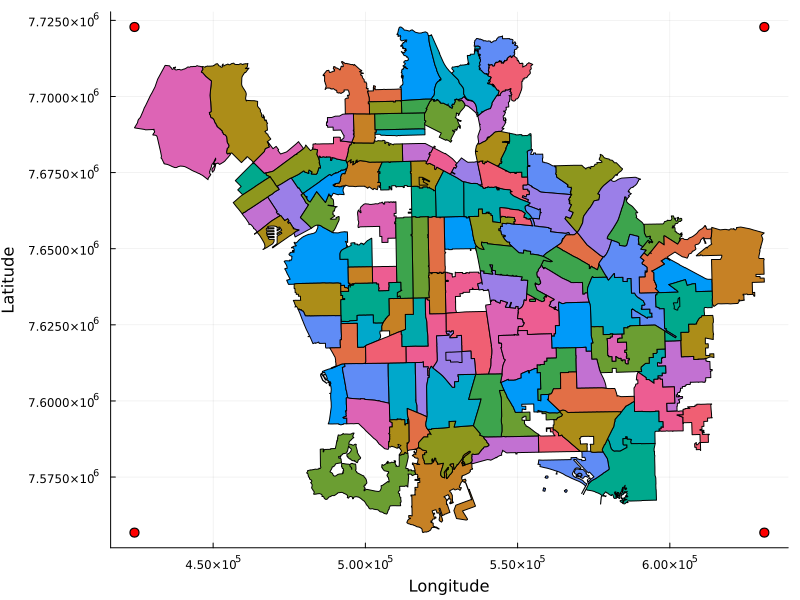

In [13]:
# Visualizar las zonas y el rectángulo
plot(data.shape)
scatter!(
    [xmin, xmax, xmax, xmin],
    [ymin, ymin, ymax, ymax],
    color = :red,
    markersize = 5,
    aspect_ratio = :equal,
    xlabel = "Longitude", ylabel = "Latitude",
    legend = false
)

# Generación de puntos y asignación

In [14]:
# Generar 10,000 puntos aleatorios dentro del rectángulo que encierra el polígono de California
ancho = abs(xmax-xmin)
alto = abs(ymax-ymin)
total_area = ancho*alto

xmin_norm = 0;
xmax_norm = 1;
ymin_norm = 0;
ymax_norm = 1;
rho_x = (xmax_norm-xmin_norm)/(xmax-xmin); #scale
rho_y = (ymax_norm-ymin_norm)/(ymax-ymin); #scale

n_points = 10000

xp = rand(xmin:xmax, n_points)
yp = rand(ymin:ymax, n_points)
points = [SVector(xp[i], yp[i]) for i in 1:n_points];

In [15]:
# Asignar puntos a las diferentes Areas
areas = []
for shape in data.shape
    shape_points = [SVector(p.x, p.y) for p in shape.points]
    if (first(shape_points).x != last(shape_points).x && first(shape_points).y != last(shape_points).y)
        push!(shape_points,first(shape_points))
    end
    push!(areas, shape_points)
end

#areas = shuffle(areas)

s = length(areas)

attachments = []
attached_points = []
y = zeros(s)
attachments_per_zip = zeros(s)
x1_sum = zeros(s)
x2_sum = zeros(s)
v_i = [[] for i = 1:s]

for point in points
    area_idx = 0
    for area in areas
        area_idx+=1
        if inpolygon(point, area, HormannAgathos(); in=true, on=false, out=false) # Algoritmo alt.: HaoSun()
            push!(attachments, area_idx) #data.OBJECTID[area_idx])
            push!(attached_points, point)
            attachments_per_zip[area_idx] += 1 
            x1_sum[area_idx] += point[1] 
            x2_sum[area_idx] += point[2]
            push!(v_i[area_idx], )
            break
        end
    end
end

In [16]:
x1 = x1_sum./attachments_per_zip;
x2 = x2_sum./attachments_per_zip;

#normalizado
x1 = (x1.-xmin).*rho_x.+xmin_norm
x2 = (x2.-ymin).*rho_y.+ymin_norm

x = hcat(x1, x2)

attachments = Int64.(attachments);
xp = [attached_points[i][1] for i = 1:length(attached_points)] 
yp = [attached_points[i][2] for i = 1:length(attached_points)] 

#normalizado
xp = (xp.-xmin).*rho_x.+xmin_norm
yp = (yp.-ymin).*rho_y.+ymin_norm

ap = hcat(xp,yp)
v_i = [ ap[findall(x->x==i,attachments),:] for i in 1:s];

In [17]:
# Visualizar la asignación
#plot(data.shape, legend=false)
#scatter!(Tuple.(attached_points), marker_z=attachments, aspect_ratio = :equal)
#scatter!(x1, x2, markersize = 10)

### Calcular la RBF ###

### Inicialización ###

In [18]:
# THETA INITIALIZATION 

x1_rbf=(xmin_norm:abs(xmax_norm-xmin_norm)/200:xmax_norm);
x2_rbf=(ymin_norm:abs(ymax_norm-ymin_norm)/200:ymax_norm);
x_rbf=[[a, b] for b in x2_rbf, a in x1_rbf]; ##el orden de b y a importa no entendí por qué.

y = zeros(s) + (data.TotalKms./maximum(data.TotalKms)*5)
K = 5
A_X = abs(xmax_norm-xmin_norm)*abs(ymax_norm-ymin_norm)
P = n_points
R = kmeans(x', K, weights = y, maxiter = 200, display=:iter);
println("========")
mu = [[R.centers'[j,1],R.centers'[j,2]] for j=1:K];
println("mu= ", mu)
mu1 = R.centers'[:,1];
mu2 = R.centers'[:,2];

sigma2 = [var(x[findall(x->x==j,assignments(R)),:]) for j in 1:K];
println("sigma2= ", sigma2)

w = calculate_w(v_i, y, mu, sigma2, A_X, P);
println("w= ", w)

theta0 = w, mu, sigma2;
theta = theta0;

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       4.068334e+00
      1       2.951724e+00      -1.116610e+00 |        5
      2       2.795351e+00      -1.563730e-01 |        4
      3       2.679138e+00      -1.162128e-01 |        5
      4       2.656850e+00      -2.228845e-02 |        5
      5       2.598103e+00      -5.874709e-02 |        2
      6       2.597391e+00      -7.118180e-04 |        0
      7       2.597391e+00       0.000000e+00 |        0
K-means converged with 7 iterations (objv = 2.5973909381899287)
mu= [[0.7572214007570287, 0.5541428054915981], [0.39781063578621545, 0.7688709612296213], [0.4500144612771117, 0.21896480491171202], [0.401191531171588, 0.4952001732093508], [0.7233048136335103, 0.30512266171589997]]
sigma2= [0.016317033093093108, 0.046244024143987206, 0.019151629181108635, 0.010202619104544158, 0.05945410606069431]
w= [175.38844308122682, 286.90735552585033, 67.25336094

In [19]:
z = rbf.(x_rbf, weights=theta[1],centers=theta[2],sigma2=theta[3]);

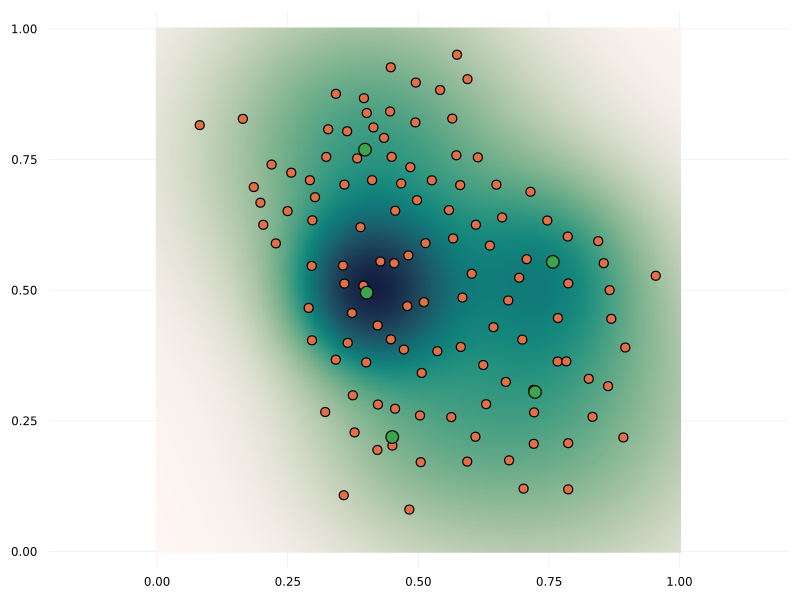

In [20]:
heatmap(x1_rbf, x2_rbf,z, aspect_ratio=:equal, c=:tempo, axis=:off, colorbar=:none)#, lims=(min(xmin,ymin),max(xmax,ymax)), colorbar=:none)
scatter!(x1, x2, legend=:none, colorbar=:none, markersize = 5)

mu_x = [mu[i][1] for i = 1:length(mu)]
mu_y = [mu[i][2] for i = 1:length(mu)]
scatter!(mu_x, mu_y, legend=:none, colorbar=:none, markersize = 7)

#annotate!([(x1[i] + 0.02, x2[i] + 0.03, text(i, :black)) for i in 1:s]) # Add Station Number
#plot!(tess, alpha=1, color=:green)

In [21]:
i = 1
v = [[v_i[i][l,1], v_i[i][l,2]] for l=1:size(v_i[i])[1]];
g_out = g.(v, w=theta[1], mu=theta[2], sigma2=theta[3])
#hcat(integrates, y);

In [22]:
integrates = zeros(s)
for i=1:s
    v = [[v_i[i][l,1], v_i[i][l,2]] for l=1:size(v_i[i])[1]];
    g_out = g.(v, w=theta[1], mu=theta[2], sigma2=theta[3])
    integrates[i] = integrate_voronoi(g_out, A_X, P)
end
error_i = integrates - y
loss = 1/2*sum(error_i.^2);
minLoss = loss;
loss_vector = [loss]
theta_vector = [theta];

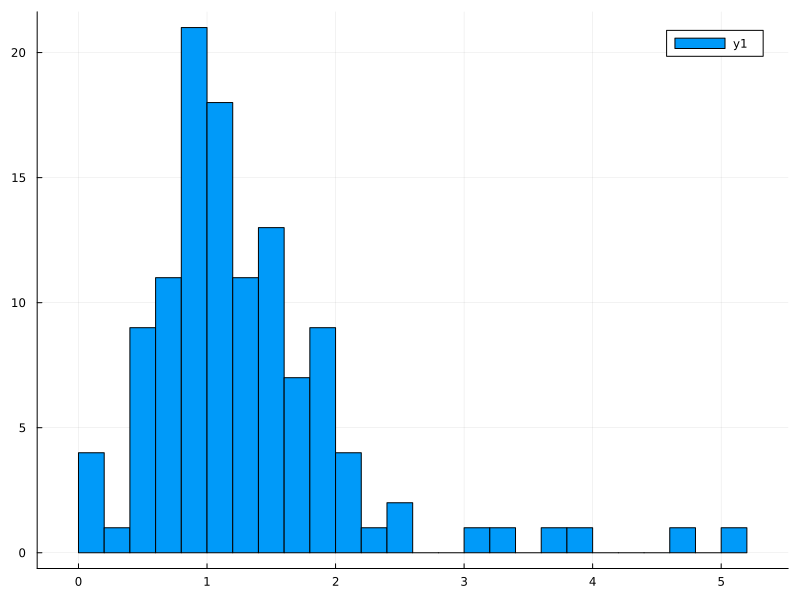

In [23]:
hist = fit(Histogram,y, nbins=25)
plot(hist)

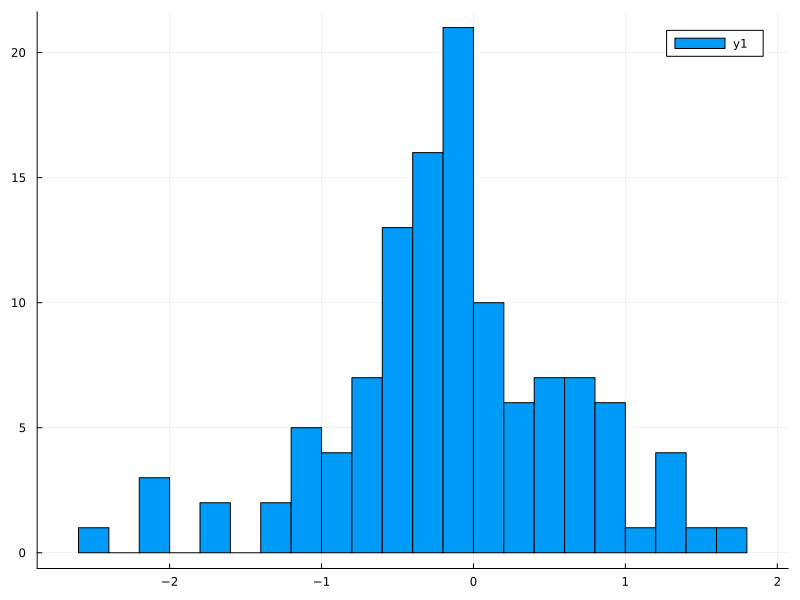

In [24]:
hist = fit(Histogram,error_i, nbins=25)
plot(hist)

Ideas:
- Tomar logaritmo de los datos (por el sesgo que tiene el error, a la izquierda) y trabajar con eso. Deshacer el cambio de variable para comparar contra este.
- Probar sin correr todo el algoritmo.

Validación leave one out:
- Probar ya con el k-means de primera (el ajuste no es malo)
- Sacar 1 zip y su "y" respectivo, utilizar el método. Se genera un ocnjunto de centros, varianzas que no dependen de ese. 
- por cada ajuste, tengo un set diferente.
- Calculo la predicción para el que dejé afuera y lo comparo. 
- Repetir para todos, da idea de la validez del método para interpolar.

Cuaderno:
- Limpiar un poco
- Dejar como antes

In [25]:
theta

([175.38844308122682, 286.90735552585033, 67.25336094745403, 420.64433359725854, 273.75000578435237], [[0.7572214007570287, 0.5541428054915981], [0.39781063578621545, 0.7688709612296213], [0.4500144612771117, 0.21896480491171202], [0.401191531171588, 0.4952001732093508], [0.7233048136335103, 0.30512266171589997]], [0.016317033093093108, 0.046244024143987206, 0.019151629181108635, 0.010202619104544158, 0.05945410606069431])

### Bucle ###

In [26]:
integration_max_steps = 100
for k = 1:integration_max_steps
    #nu = max(nu*nu_decay, nu_min)
    nu = 0.001
    
    # ========== STEP ========== 
    oldTheta = theta;
    dL = integrate(v_i, theta, error_i);
#    println("theta: ", theta)
#    println("   dL: ",dL)
    theta = theta .- nu.*dL;
    w = calculate_w(v_i, y, theta[2], theta[3], A_X, P); # Calcular weights por minimos cuadrados
    theta = w, theta[2], theta[3]; # Fixme: no me dejó sobreescribir, tuve que armar los 3 datos
    push!(theta_vector, theta);
    # ===========================
    
    # ========== Check if mu is still inside the area ========== 
#    mux = [theta[2][i][1] for i = 1:length(theta[2])];
#    muy = [theta[2][i][2] for i = 1:length(theta[2])];
#    inside_x = minimum(mux) > xmin_norm && maximum(mux) <= xmax_norm;
#    inside_y = minimum(muy) > ymin_norm && maximum(muy) <= ymax_norm;
#    inside = inside_x && inside_y
#    if !inside
#        #println("Una de las RBF se salio del cuadrado, en ", k, " iteraciones.");
#        #break
#    end
    # ========================================================== 

    # ========== Recalculate ========== 
    integrates = zeros(s)
    for i=1:s
        v = [[v_i[i][l,1], v_i[i][l,2]] for l=1:size(v_i[i])[1]];
        g_out = g.(v, w=theta[1], mu=theta[2], sigma2=theta[3]);
        integrates[i] = integrate_voronoi(g_out, A_X, P);
    end
    error_i = integrates - y;
    # =================================
    
    # ========== Comprobar descenso ==========
    oldLoss = loss
    loss = 1/2*sum(error_i.^2);
    push!(loss_vector, loss);
    if (length(loss_vector) > 50 && loss > oldLoss)
        println("cortar por umbral en ", k, " iteraciones")
        k = integration_max_steps
        break
    end
    # ========================================
end

cortar por umbral en 73 iteraciones


In [27]:
theta = theta_vector[length(theta_vector)-1]

([-344.5566867563756, 306.0346640520546, 185.82752685333443, 361.64157973841407, 577.5175554763257], [[0.8558717804486243, 0.5505817672992188], [0.44279968002630016, 0.7304088820533696], [0.41090880887811726, 0.2447872030314404], [0.35901707302362323, 0.4774622850265721], [0.9144608184375115, 0.49236723166498164]], [0.016317033093093108, 0.046244024143987206, 0.019151629181108635, 0.010202619104544158, 0.05945410606069431])

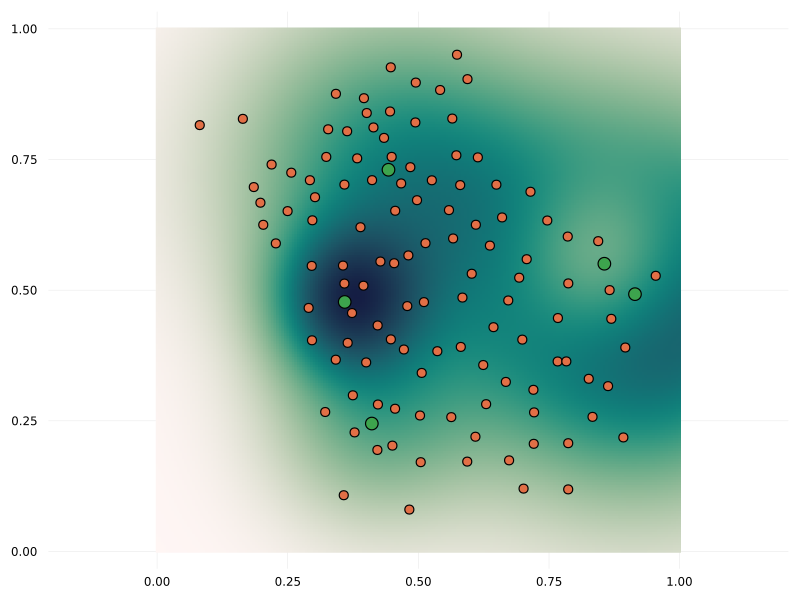

In [28]:
z = rbf.(x_rbf, weights=theta[1],centers=theta[2],sigma2=theta[3]);

heatmap(x1_rbf, x2_rbf,z, aspect_ratio=:equal, c=:tempo, axis=:off,colorbar=:none)#, lims=(min(X1_min,X2_min),max(X1_max,X2_max)))
scatter!(x1, x2, legend=:none, colorbar=:none, markersize = 5)

mu_x = [theta[2][i][1] for i = 1:length(theta[2])]
mu_y = [theta[2][i][2] for i = 1:length(theta[2])]
scatter!(mu_x, mu_y, legend=:none, colorbar=:none, markersize = 7)

In [29]:
plot(fit(Histogram, error_i_final, nbins=25))

LoadError: UndefVarError: error_i_final not defined

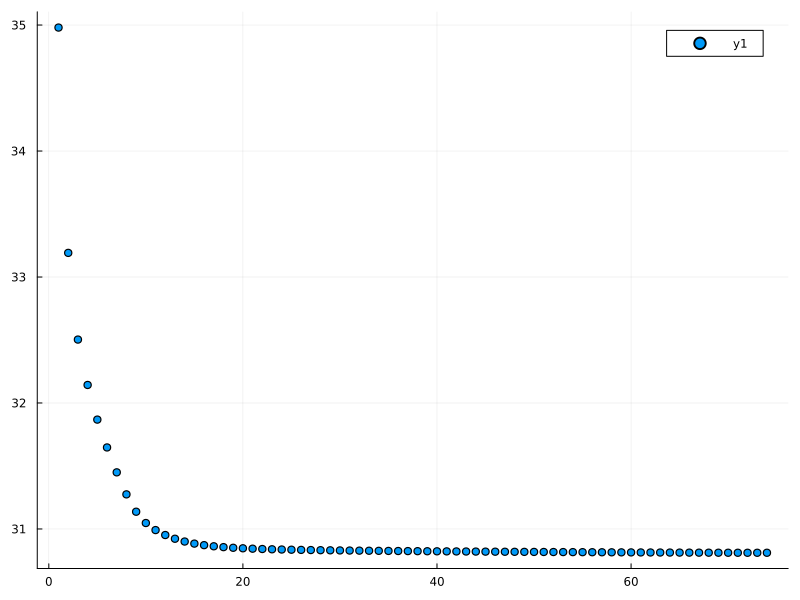

In [30]:
scatter(loss_vector)

In [31]:
theta

([-344.5566867563756, 306.0346640520546, 185.82752685333443, 361.64157973841407, 577.5175554763257], [[0.8558717804486243, 0.5505817672992188], [0.44279968002630016, 0.7304088820533696], [0.41090880887811726, 0.2447872030314404], [0.35901707302362323, 0.4774622850265721], [0.9144608184375115, 0.49236723166498164]], [0.016317033093093108, 0.046244024143987206, 0.019151629181108635, 0.010202619104544158, 0.05945410606069431])

In [32]:
theta0

([175.38844308122682, 286.90735552585033, 67.25336094745403, 420.64433359725854, 273.75000578435237], [[0.7572214007570287, 0.5541428054915981], [0.39781063578621545, 0.7688709612296213], [0.4500144612771117, 0.21896480491171202], [0.401191531171588, 0.4952001732093508], [0.7233048136335103, 0.30512266171589997]], [0.016317033093093108, 0.046244024143987206, 0.019151629181108635, 0.010202619104544158, 0.05945410606069431])

In [33]:
hcat(y, integrates, integrates.-y)

117×3 Matrix{Float64}:
 1.16089   1.0283    -0.132596
 2.0661    1.15237   -0.913728
 1.12576   0.690328  -0.435432
 0.944006  0.470118  -0.473888
 1.7517    0.78158   -0.97012
 0.0       1.0549     1.0549
 1.08039   0.910499  -0.169892
 1.88065   1.06327   -0.817376
 1.01693   0.666975  -0.349959
 1.97132   0.862755  -1.10857
 0.53638   0.502492  -0.0338884
 0.352957  0.352648  -0.000308704
 2.04271   1.27021   -0.772495
 ⋮                   
 0.780143  1.54144    0.761296
 1.66778   2.03517    0.367389
 0.854552  1.2856     0.431048
 0.498202  0.718782   0.22058
 1.03669   0.257297  -0.779395
 2.45508   1.64154   -0.81354
 1.10407   0.768521  -0.33555
 1.28109   0.970015  -0.311074
 1.67381   2.03257    0.358765
 0.915492  1.60069    0.685202
 0.984145  0.664961  -0.319183
 1.93933   1.27947   -0.659859

In [34]:
minimum(loss_vector)

30.811090447605242

In [35]:
loss_vector

74-element Vector{Float64}:
 34.98000566114941
 33.19153957735074
 32.50342950778691
 32.14312270148829
 31.868104256892376
 31.647090948104328
 31.449527400026305
 31.274752692321652
 31.13693940080125
 31.047265778458314
 30.991243626874507
 30.951966754989154
 30.922452969839867
  ⋮
 30.813138728782768
 30.81283533117824
 30.81254290495938
 30.812262208563013
 30.811997219591813
 30.8117494389683
 30.811527634837283
 30.811333978771813
 30.811188307295048
 30.81109167610438
 30.811090447605242
 30.811176000158586

In [36]:
w_vector = [theta_vector[l][1] for l=1:length(theta_vector)]
mu_vector = [theta_vector[l][2] for l=1:length(theta_vector)]
sigma2_vector = [theta_vector[l][3] for l=1:length(theta_vector)]
mux_vector = [[mu_vector[l][k][1] for k=1:K] for l=1:length(mu_vector)]
muy_vector = [[mu_vector[l][k][2] for k=1:K] for l=1:length(mu_vector)];

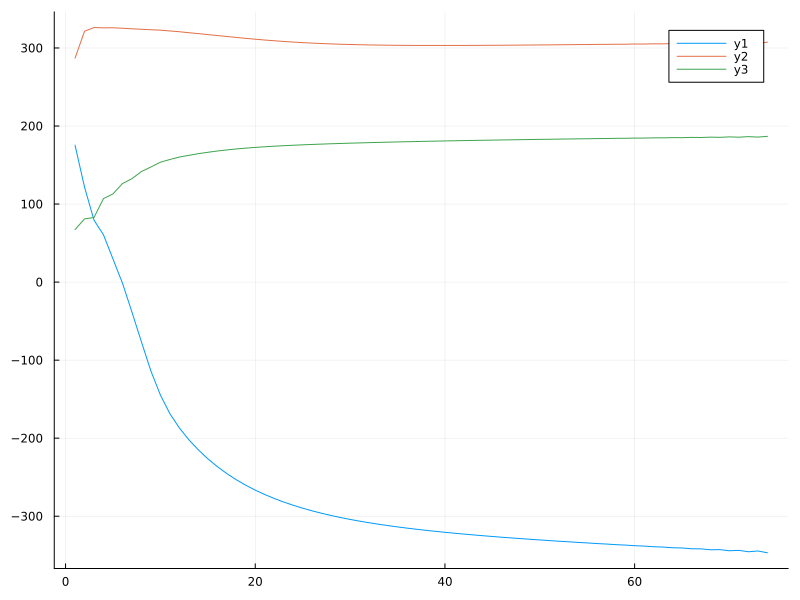

In [37]:
 plot([w_vector[l][1] for l=1:length(w_vector)])
plot!([w_vector[l][2] for l=1:length(w_vector)])
plot!([w_vector[l][3] for l=1:length(w_vector)])

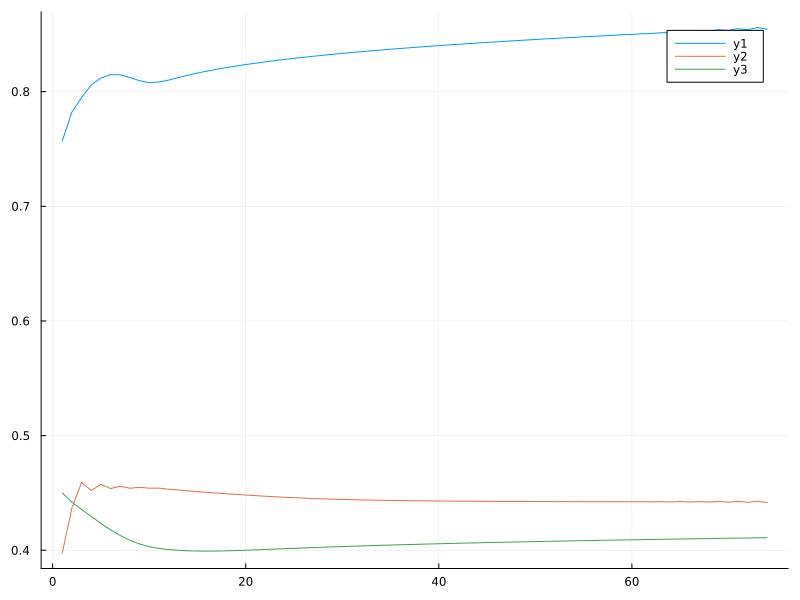

In [38]:
 plot([mux_vector[l][1] for l=1:length(mu_vector)])
plot!([mux_vector[l][2] for l=1:length(mu_vector)])
plot!([mux_vector[l][3] for l=1:length(mu_vector)])

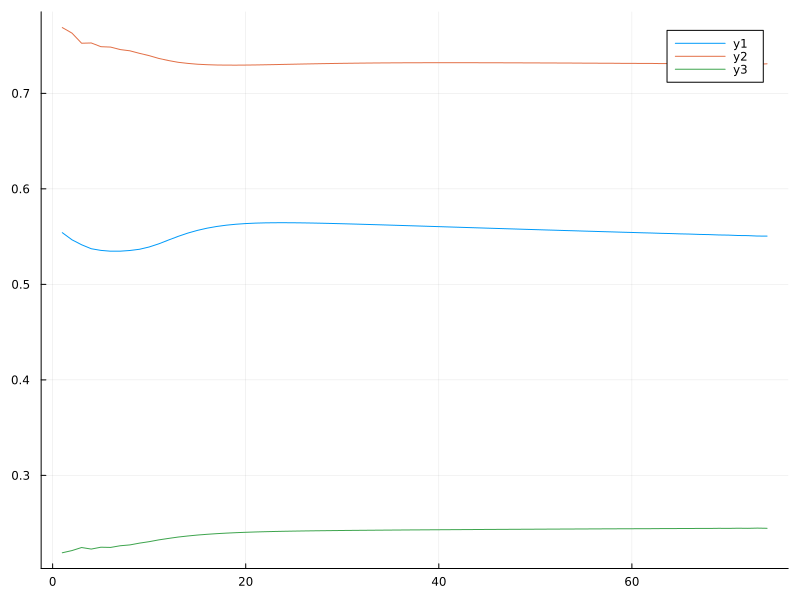

In [39]:
 plot([muy_vector[l][1] for l=1:length(mu_vector)])
plot!([muy_vector[l][2] for l=1:length(mu_vector)])
plot!([muy_vector[l][3] for l=1:length(mu_vector)])

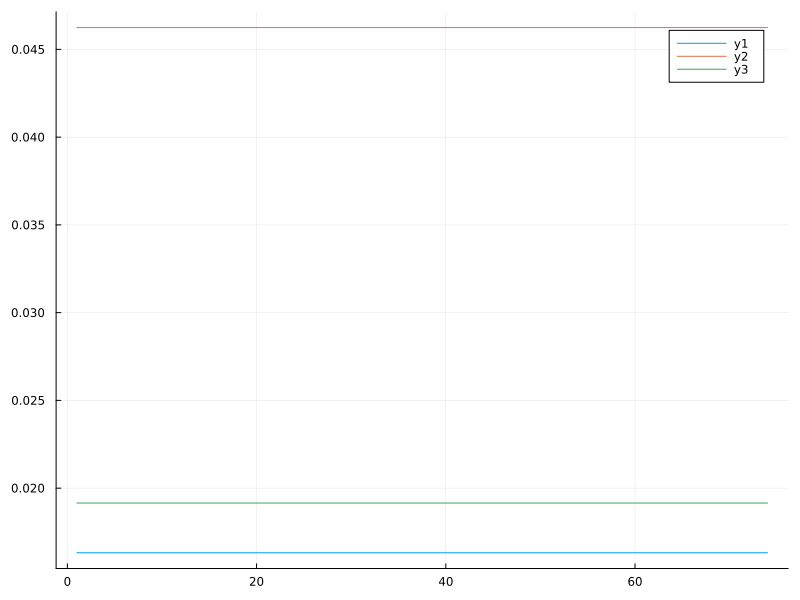

In [40]:
 plot([sigma2_vector[l][1] for l=1:length(sigma2_vector)])
plot!([sigma2_vector[l][2] for l=1:length(sigma2_vector)])
plot!([sigma2_vector[l][3] for l=1:length(sigma2_vector)])